# Z-score tells how many standard deviations away a given observation is from
# the mean. For example, a Z score of 2.5 means that the data point is 2.5 standard
# deviation far from the mean. And since it is far from the center, it’s flagged as
# an outlier/anomaly. The Z-score measures how far a data point is away from the
# mean as a signed multiple of the standard deviation. Large absolute values of
# the Z-score suggest an anomaly.

# Given the multimodal, Gaussian-like peaks in the tcp.len distribution,
# it's clear that the dataset exhibits complex patterns. In such cases, traditional
# anomaly detection methods like z-score might not be sufficient, as they assume a
# unimodal (single peak) Gaussian distribution. Instead, we should consider more advanced
# techniques that can handle multimodal distributions:

#  GMM : A Gaussian mixture model is a probabilistic model that assumes all the data
#  points are generated from a mixture of a finite number of Gaussian distributions with
#  unknown parameters.

# Gaussian Mixture Models are ideal for data with multiple Gaussian-like peaks.
# They assume that the data is generated from a mixture of several Gaussian distributions.
# GMM can learn these distributions and can then be used to calculate the likelihood of
# each data point belonging to each distribution. Points with low likelihood can be
# considered anomalies.


it's essential to standardize my data because GMM is sensitive to the scale of the data.

In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve


In [2]:
df = joblib.load('df_chosen_features.csv')
df.shape

(1000000, 5)

In [3]:
scaler = StandardScaler()
df['tcp.len_scaled'] = scaler.fit_transform(df[['tcp.len']])

In [6]:
df.loc[:, ['tcp.len', 'tcp.len_scaled']]

,tcp.len,tcp.len_scaled
0,152.0,-0.742174
1,1200.0,1.345084
2,0.0,-1.044906
3,187.0,-0.672466
4,1204.0,1.353051
...,...,...
999995,197.0,-0.652549
999996,1448.0,1.839016
999997,645.0,0.239714
999998,1448.0,1.839016


Choosing the Number of Components
The number of components (Gaussians) in myGMM should correspond to the number of modes (peaks) I expect in your data. From your previous observations, I will start with 4 components.

Fitting the Gaussian Mixture Model

In [9]:
# Initialize GMM
gmm = GaussianMixture(n_components=4, random_state=0)

In [10]:
# Fit the model
gmm.fit(df[['tcp.len_scaled']])

ValueError: Input X contains NaN.
GaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [11]:
df['tcp.len_scaled'].describe()

count    9.987780e+05
mean     9.876178e-17
std      1.000001e+00
min     -1.044906e+00
25%     -7.780239e-01
50%     -3.478256e-01
75%      2.835303e-01
max      1.862916e+00
Name: tcp.len_scaled, dtype: float64

In [12]:
df['tcp.len_scaled'].isna().any()


True

In [13]:
df['tcp.len_scaled'].isna().sum()

1222

In [16]:
df['tcp.len'].isna().sum()/df.shape[0] * 100

0.1222

12 % of the feature is NaN. I will drop them for now

In [17]:
df = df.dropna(subset=['tcp.len_scaled'])

In [19]:
df.shape

(998778, 6)

In [20]:
gmm.fit(df[['tcp.len_scaled']])


GaussianMixture(n_components=4, random_state=0)

In [21]:
# Predict the labels
labels = gmm.predict(df[['tcp.len_scaled']])

In [36]:
labels
# After fitting the model, when we use gmm.predict, the model assigns each data point in the dataset to one of these Gaussian components. The assignment is based on which Gaussian distribution the data point most likely belongs to.

array([2, 1, 3, ..., 0, 1, 0])

Identifying Anomalies
Anomalies can be detected as data points that have a low likelihood of being generated by any of the Gaussian components. I can use the score_samples method, which gives the log-likelihood of each sample. A threshold is then set to flag anomalies.

In [22]:
# For a GMM, the likelihood of a single data point is the probability that this point was generated by one of the Gaussian distributions that make up the model.

# Logarithm of Likelihood (Log-Likelihood): Since probabilities can be very small numbers, it's common to use the logarithm of the likelihood, which transforms the product of probabilities into a sum of logarithms. This makes calculations more manageable and helps avoid numerical underflow, which can occur when working with very small numbers.

# In anomaly detection, data points that have a very low log-likelihood (i.e., they are very unlikely to have been generated by any of the Gaussian distributions in the model) can be considered anomalies.

# Calculate log-likelihood of each sample

log_likelihood = gmm.score_samples(df[['tcp.len_scaled']])

In [37]:
log_likelihood

array([-0.83247261, -1.64080514,  4.47061149, ...,  0.04258206,
       -1.42906182,  0.17661217])

In [26]:
# Set a threshold for anomaly detection --> can be adjusted later
threshold = np.percentile(log_likelihood, 5)

In [38]:
# The idea here is to use this 5th percentile value as a threshold. Any data point whose log-likelihood is below this threshold is considered an anomaly.
threshold

-1.8629465569950379

In [34]:
# Flag anomalies
df['anomaly'] = log_likelihood < threshold

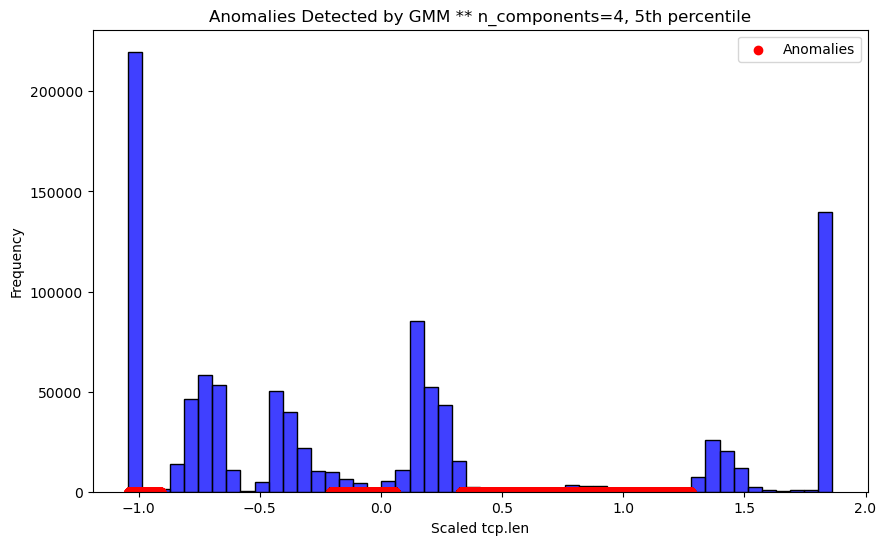

In [41]:
# Visualization and Analysis
# Finally, it's a good practice to visualize the results to understand the distribution of anomalies.

plt.figure(figsize= (10,6))
sns.histplot(df['tcp.len_scaled'],
             bins=50,
             kde=False,
             color='blue')

anomalies = df[df['anomaly']]
plt.scatter(anomalies['tcp.len_scaled'],
            [0] * len(anomalies),
            color='red',
            label='Anomalies')
plt.legend()
plt.title('Anomalies Detected by GMM ** n_components=4, 5th percentile')
plt.xlabel('Scaled tcp.len')
plt.ylabel('Frequency')
plt.show()


The red dots signify the anomalies as determined by the GMM. These are likely the data points that fell below the 5th percentile of the log-likelihood values computed by the GMM, indicating that they are less likely to have been generated by any of the Gaussian components in the model.

I have the original df where I can go anc check these anomalies one by one I also have a column in the original df called "alert: Packet classification for "benign" or "suspicious"." An additional column has been added to label each row as either "benign" or "suspicious". The "benign" label represents normal network traffic, primarily from the Normal Windows PC, while the "suspicious" label represents potential attack traffic, mainly sourced from the Kali machine attacking the OWASP server.


In [42]:
filepath = "attack-sample.csv"
df_original = pd.read_csv(filepath)

/tmp/ipykernel_390100/1098512052.py:2: DtypeWarning: Columns (34,37,44,50,52,54,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(filepath)


In [43]:
df_original.columns

Index(['frame.number', 'frame.len', 'frame.time', 'frame.time_epoch',
       'frame.protocols', 'eth.src', 'eth.dst', 'eth.type', 'ip.src', 'ip.dst',
       'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto',
       'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn',
       'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size',
       'tcp.checksum', 'tcp.stream', 'udp.srcport', 'udp.dstport',
       'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum',
       'http.request.method', 'http.request.uri', 'http.request.version',
       'http.request.full_uri', 'http.response.code', 'http.user_agent',
       'http.content_length_header', 'http.content_type', 'http.cookie',
       'http.host', 'http.referer', 'http.location', 'http.authorization',
       'http.connection', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class',
       'dns.flags.response', 'dns.f

In [44]:
# df_original['tcp.len'].isna().sum() 1222
# I will dropp them

1222

In [0]:
sub_df_original = df_original.loc[:, ['tcp.len', 'alert']]
sub_df_original = sub_df_original.dropna(subset=['tcp.len'])

In [48]:
sub_df_original.shape

(998778, 2)

In [49]:
df.anomaly

0         False
1         False
2         False
3         False
4         False
          ...  
999995    False
999996    False
999997    False
999998    False
999999    False
Name: anomaly, Length: 998778, dtype: bool

In [50]:
sub_df_original['anomaly'] = df['anomaly']


In [60]:
sub_df_original.head(10)

,tcp.len,alert,anomaly
0,152.0,suspicious,False
1,1200.0,suspicious,False
2,0.0,suspicious,False
3,187.0,suspicious,False
4,1204.0,suspicious,False
5,1448.0,suspicious,False
6,580.0,suspicious,False
7,1214.0,suspicious,False
8,187.0,suspicious,False
9,346.0,suspicious,False


In [72]:
sub_df_original['alert'].value_counts()

alert
suspicious    996126
benign          2652
Name: count, dtype: int64

In [73]:
sub_df_original['anomaly'].value_counts()

anomaly
False    948912
True      49866
Name: count, dtype: int64

In [55]:
sub_df_original.loc[(sub_df_original['anomaly'] == True) & (sub_df_original['alert'] == 'suspicious')]

,tcp.len,alert,anomaly
27,455.0,suspicious,True
38,695.0,suspicious,True
42,973.0,suspicious,True
86,973.0,suspicious,True
122,475.0,suspicious,True
...,...,...,...
999944,553.0,suspicious,True
999948,915.0,suspicious,True
999977,436.0,suspicious,True
999981,423.0,suspicious,True


since I have labels ('suspicious' or 'benign'), I can use them to evaluate the performance of my GMM as an anomaly detection system.
Calculating precision and recall:
True Positives (TP): The count of 'suspicious' instances correctly identified as anomalies.
False Positives (FP): The count of 'benign' instances incorrectly identified as anomalies.
False Negatives (FN): The count of 'suspicious' instances not identified as anomalies.

In [61]:
TP = ((sub_df_original['alert'] == 'suspicious') & (sub_df_original['anomaly'] == True)).sum()
FP = ((sub_df_original['alert'] == 'benign') & (sub_df_original['anomaly'] == True)).sum()
FN = ((sub_df_original['alert'] == 'suspicious') & (sub_df_original['anomaly'] == False)).sum()


In [62]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f'Precision is: {precision} \nRecall is: {recall}')

Precision is: 0.998315485501143 
Recall is: 0.04997560549569031


I have a very high precision and very low recall. I higher recall. I should beable to at least catch 30% of anomalies.

Checking the confusion matrix

In [68]:
# Convert 'suspicious'/'benign' to a binary format where 'suspicious' is 1 and 'benign' is 0
true_labels = (sub_df_original['alert'] == 'suspicious').astype(int)

# Convert boolean 'anomaly' flags to binary format
predicted_labels = sub_df_original['anomaly'].astype(int)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [65]:
cm

array([[  2568,     84],
       [946344,  49782]])

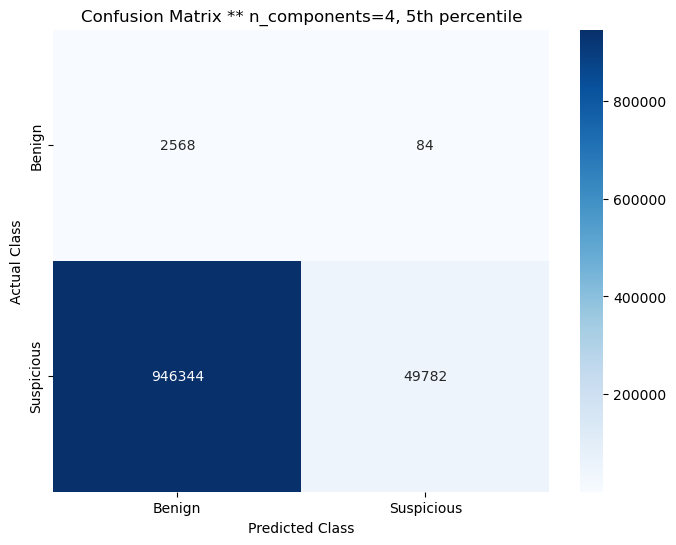

In [78]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Benign', 'Suspicious'],
            yticklabels=['Benign', 'Suspicious'])
plt.title('Confusion Matrix ** n_components=4, 5th percentile')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

To plot a Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) for my Gaussian Mixture Model (GMM), I would typically need a way to rank my predictions based on their likelihood of being an anomaly. The GMM provides the score_samples method which returns the log-likelihood of each sample. I can use the negative log-likelihood as a "score" to rank the anomalies—the higher the score, the more likely it is to be an anomaly.

I have my anomaly scores as
log_likelihood = gmm.score_samples(df[['tcp.len_scaled']]) and have my
true_labels = (sub_df_original['alert'] == 'suspicious').astype(int)


In [69]:
fpr, tpr, thresholds = roc_curve(true_labels, log_likelihood)

In [70]:
roc_auc = roc_auc_score(true_labels, log_likelihood)

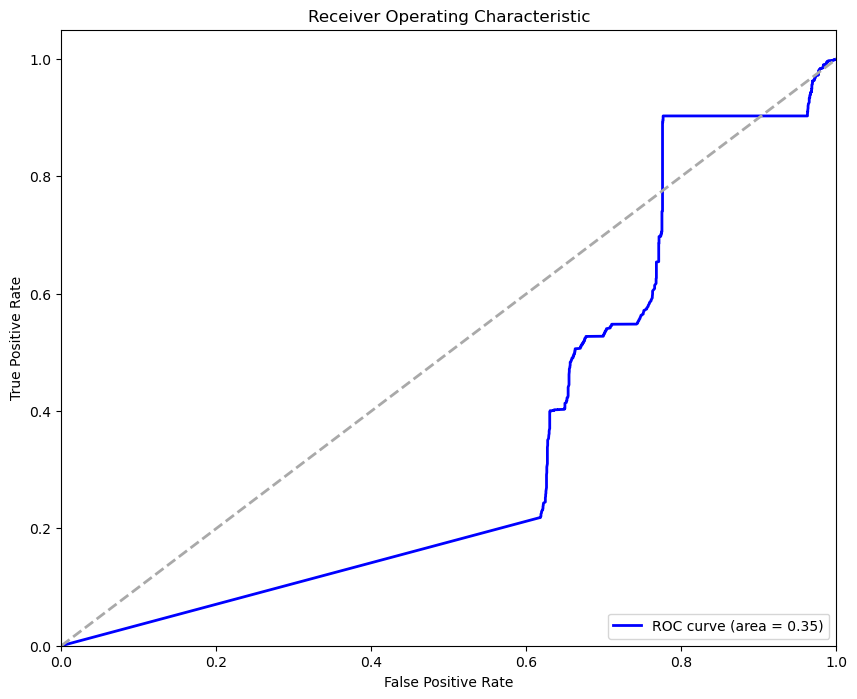

In [71]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve is a graphical representation of the trade-off between the true positive rate and false positive rate at various thresholds.
AUC represents the likelihood that a randomly chosen positive instance is ranked higher than a randomly chosen negative one.
AUC values range from 0 to 1, where 1 indicates a perfect model and 0.5 indicates a model with no discriminative power.

considering it's an imbalanced dataset, precision-recall curve is a better representation

precision_recall_curve function computes precision and recall for different thresholds:

In [75]:
precision, recall, threshold2s = precision_recall_curve(true_labels, log_likelihood)

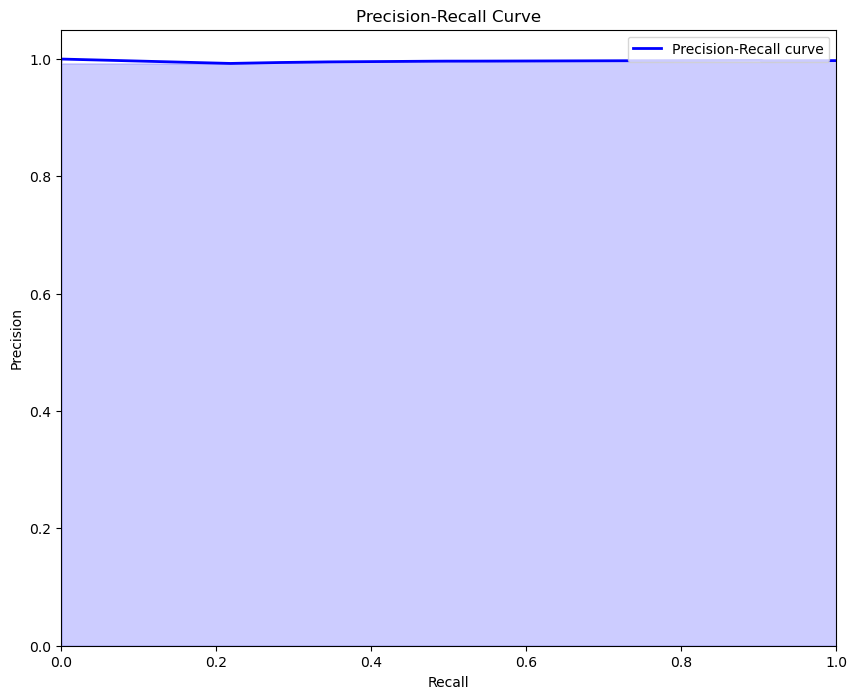

In [76]:
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.show()
